In [2]:
import gdrive_refs as names
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
root = "./data/"
datasets = dict()
for name in names.gdrive_dic:
    address = root+name[1]
    datasets[name[1]] = pd.read_csv(address, on_bad_lines='skip')

# Checking for NaN values in datasets

After loading the datasets, we want to make sure it is exploitable and perform cleaning if necessary. To do so, we will print the heatmaps relating entries of datasates with a color indicating whether there is or not a NaN value in the data.

Progress: Step 1/26
Progress: Step 2/26
Progress: Step 3/26
Progress: Step 4/26
Progress: Step 5/26
Progress: Step 6/26
Progress: Step 7/26
Progress: Step 8/26
Progress: Step 9/26
Progress: Step 10/26
Progress: Step 11/26
Progress: Step 12/26
Progress: Step 13/26
Progress: Step 14/26
Progress: Step 15/26
Progress: Step 16/26
Progress: Step 17/26
Progress: Step 18/26
Progress: Step 19/26
Progress: Step 20/26
Progress: Step 21/26
Progress: Step 22/26
Progress: Step 23/26
Progress: Step 24/26
Progress: Step 25/26
Progress: Step 26/26


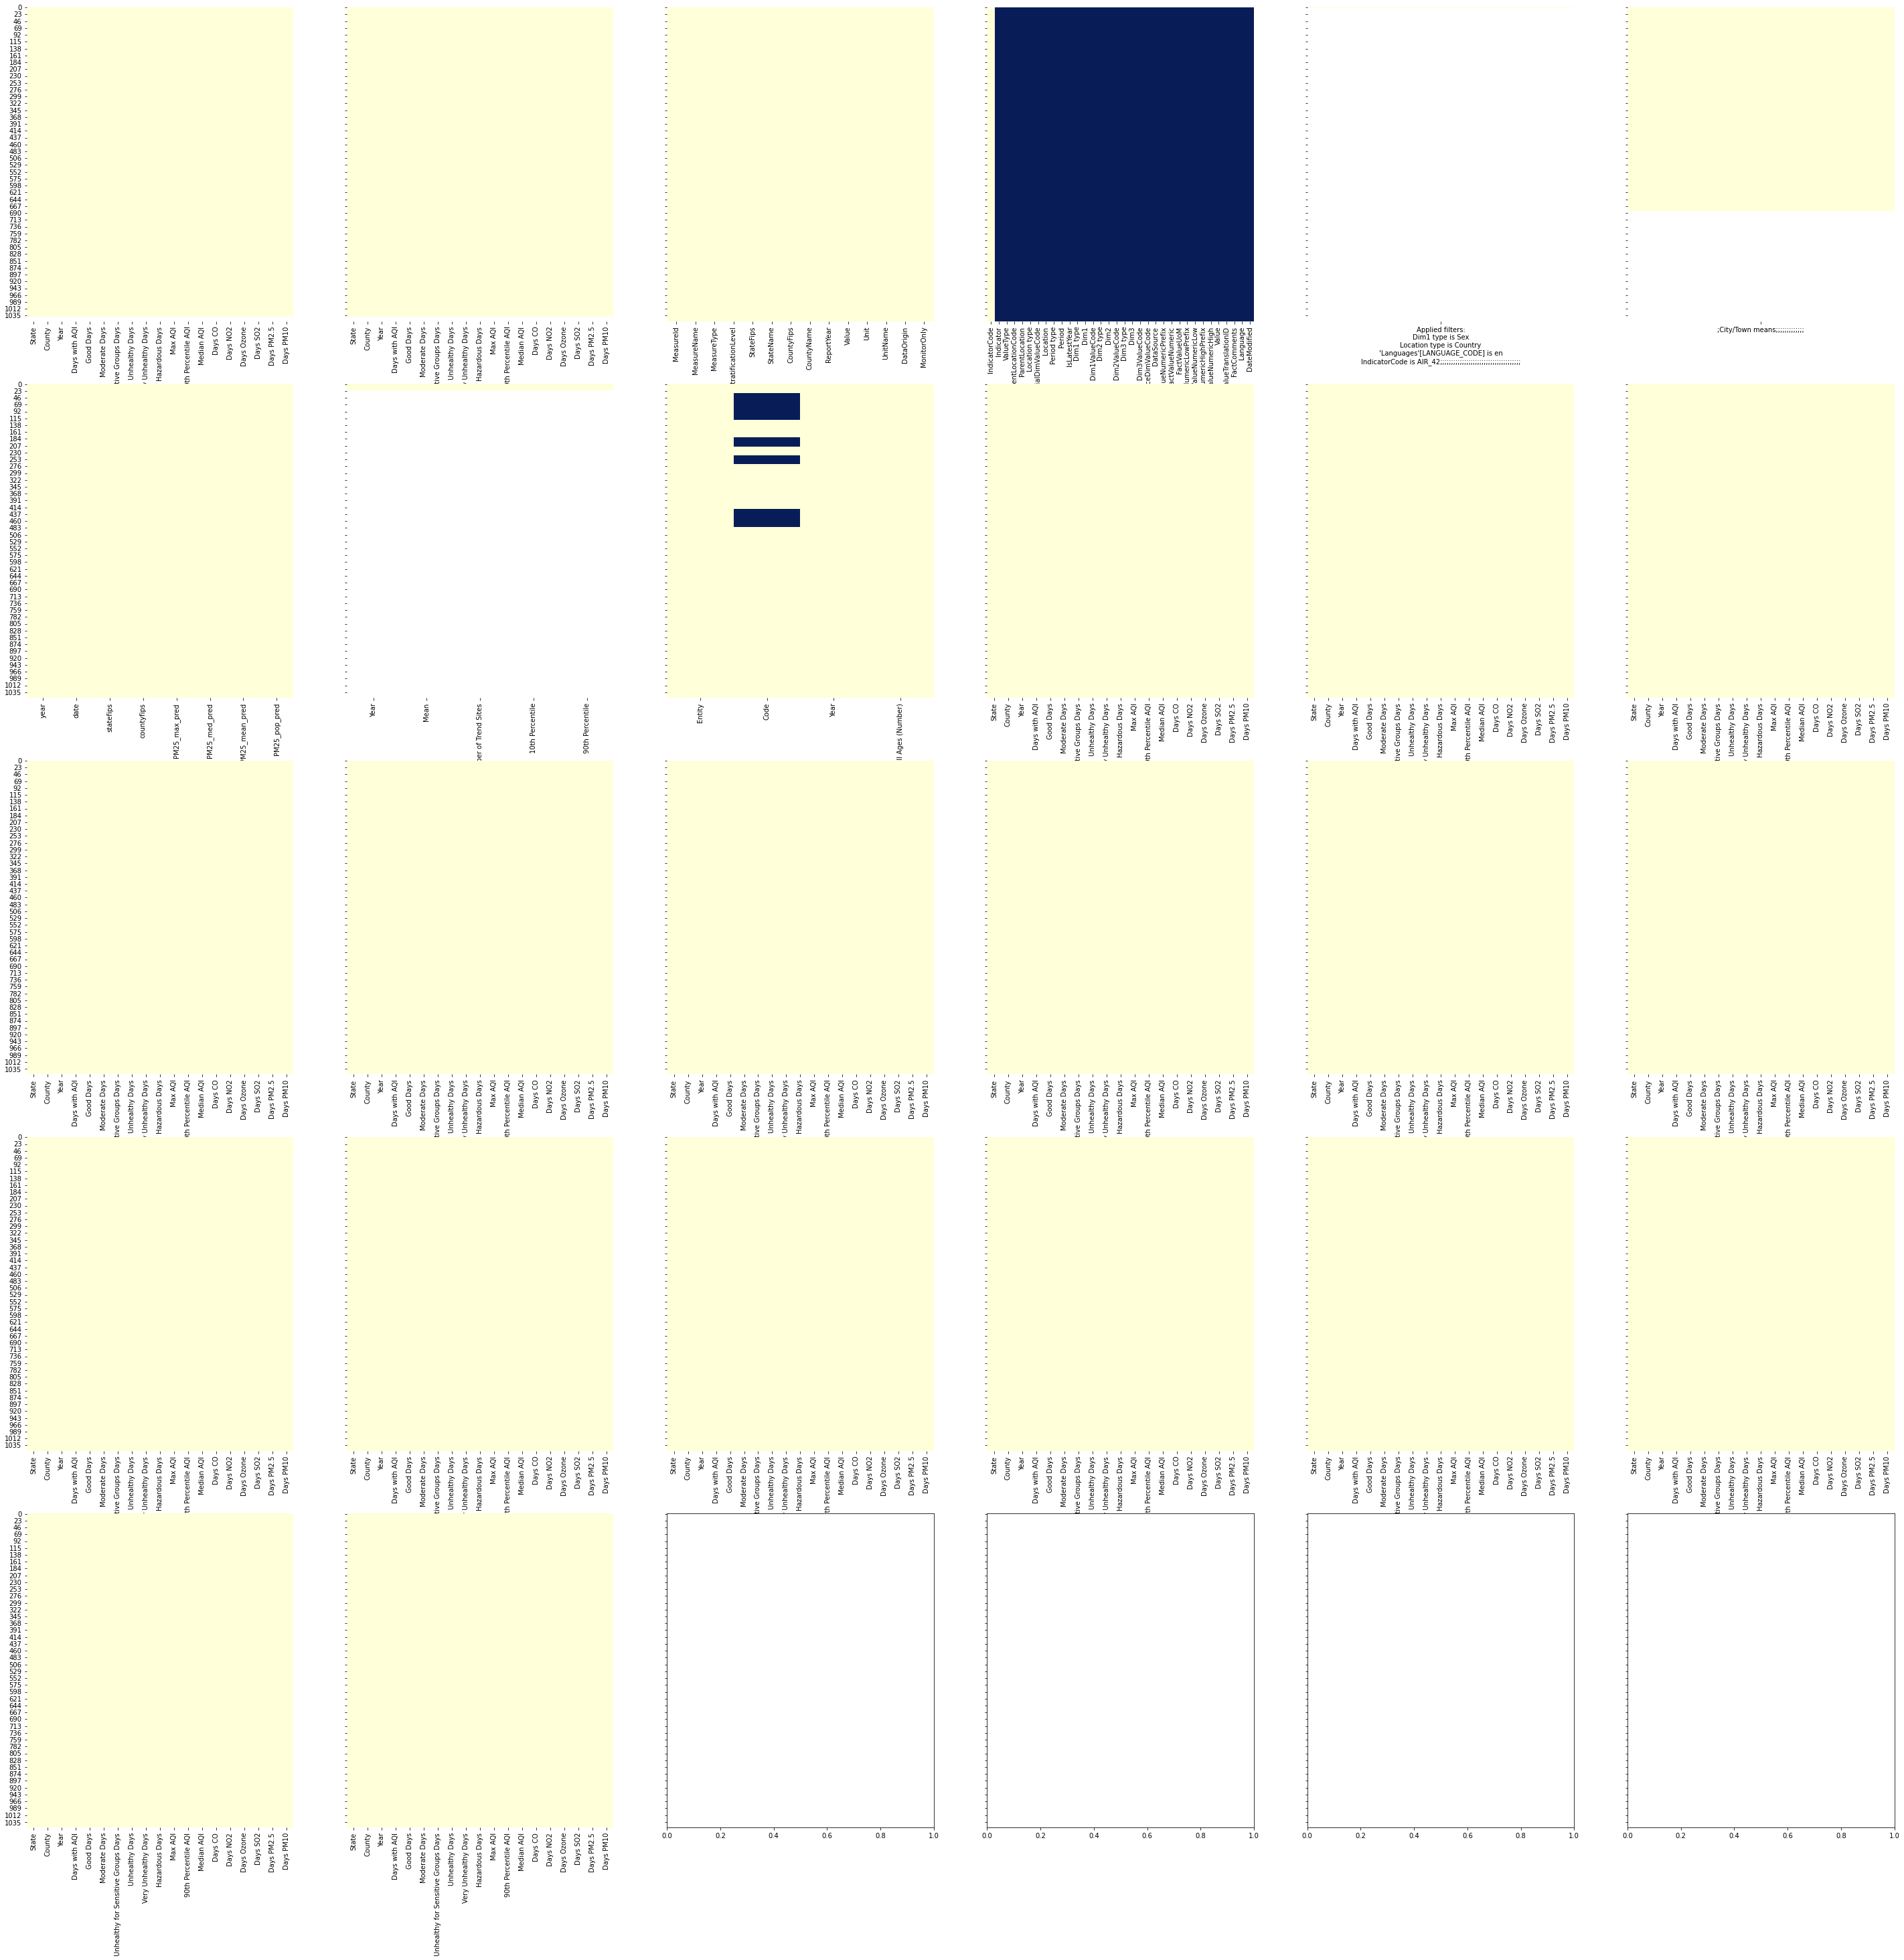

In [3]:
# CAREFUL: THIS TAKES A LONG TIME TO RUN
# Visualization of Null values
n = len(datasets)
keys = list(datasets.keys())
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
fig, axs = plt.subplots(int(np.sqrt(n)),int(np.sqrt(n))+1, figsize=(50, 50), sharey=True)
for i in range(n):
    print("Progress: Step {}/{}".format(i+1,n))
    df = datasets[keys[i]]
    # Reference: https://dev.to/tomoyukiaota/visualizing-the-patterns-of-missing-value-occurrence-with-python-46dj
    sns.heatmap(df.isnull(),cmap="YlGnBu", cbar=False, ax = axs.flat[i])

Our data is not emptyn we can proceed and perform EDA.

In [4]:
n = len(datasets)
keys = list(datasets.keys())
for i in range(n):
    df = datasets[keys[i]]
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   State                                1040 non-null   object
 1   County                               1040 non-null   object
 2   Year                                 1040 non-null   int64 
 3   Days with AQI                        1040 non-null   int64 
 4   Good Days                            1040 non-null   int64 
 5   Moderate Days                        1040 non-null   int64 
 6   Unhealthy for Sensitive Groups Days  1040 non-null   int64 
 7   Unhealthy Days                       1040 non-null   int64 
 8   Very Unhealthy Days                  1040 non-null   int64 
 9   Hazardous Days                       1040 non-null   int64 
 10  Max AQI                              1040 non-null   int64 
 11  90th Percentile AQI                  1040 n

# Relating death tolls, AQI, and PM2.5

One of our goals in this project is to relate deaths tolls of air pollution to the data we have in the dataset of the class. One way to do it is to use data from the WHO and relate deaths to PM2.5. However, we would like to predict death tolls using the Air Quality Index (AQI) since this is one of the few metrics we have in our original dataset. 

In [13]:
years = [str(i) for i in range(2001,2017)]
annual_aqi_us_county = datasets["annual_aqi_by_county_2000.csv"].loc[:,['Year', 'State', 'County','Median AQI']]
increment = 1
for year in years:
    df = datasets["annual_aqi_by_county_"+year+".csv"].loc[:,['Year', 'State', 'County','Median AQI']]
    annual_aqi_us_county = pd.concat([annual_aqi_us_county, df], axis=0)
    increment += 1

In [14]:
annual_aqi_us_county

,Year,State,County,Median AQI
0,2000,Alabama,Baldwin,54
1,2000,Alabama,Clay,46
2,2000,Alabama,Colbert,16
3,2000,Alabama,DeKalb,51
4,2000,Alabama,Elmore,50
...,...,...,...,...
1049,2016,Wyoming,Sublette,44
1050,2016,Wyoming,Sweetwater,44
1051,2016,Wyoming,Teton,41
1052,2016,Wyoming,Uinta,42


In [53]:
d = dict(zip(tuple([i for i in range(1,len(annual_aqi_us_county)+1)]),tuple(annual_aqi_us_county['County'].unique()))) 

pm25_county = datasets["Daily_PM25_Concentrations_All_County_2001-2016.csv"]
pm25_county['county'] = pm25_county['statefips'].replace(d)
pm25_county_mean_year = pm25_county.loc[:,['year','county','PM25_med_pred']].groupby(['year','county']).mean()
pm25_county_mean_year

PM25_med_pred
year county                   
2001 Anchorage       14.521819
     Apache           7.498585
     Ashley          11.683080
     Baldwin         12.991030
     Clark           13.097615
...                        ...
2016 Talladega        8.545966
     Tuscaloosa       8.488591
     Walker           5.868054
     Yavapai          5.880199
     Yuma             8.696703

[784 rows x 1 columns]

,PM25_med_pred,Median AQI,log Median AQI,log PM25_med_pred
PM25_med_pred,1.000000,-0.034127,-0.035171,0.989582
Median AQI,-0.034127,1.000000,0.944856,-0.050301
log Median AQI,-0.035171,0.944856,1.000000,-0.046085
log PM25_med_pred,0.989582,-0.050301,-0.046085,1.000000


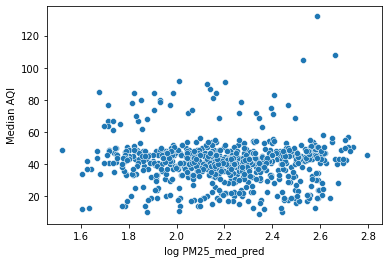

In [81]:
annual_aqi_us = annual_aqi_us_county.loc[:,['Year','County','Median AQI']].groupby(['Year','County']).mean()
joined_aqi_pm25_us = pm25_county_mean_year.merge(annual_aqi_us, left_on = pm25_county_mean_year.index, right_on = annual_aqi_us.index)
joined_aqi_pm25_us['log Median AQI'] = joined_aqi_pm25_us['Median AQI'].apply(np.log)
joined_aqi_pm25_us['log PM25_med_pred'] = joined_aqi_pm25_us['PM25_med_pred'].apply(np.log)
#joined_aqi_pm25_us['Median AQI^2'] = joined_aqi_pm25_us['Median AQI'].apply(np.square)
#joined_aqi_pm25_us['Mean^2'] = joined_aqi_pm25_us['Mean'].apply(np.square)
sns.scatterplot(data = joined_aqi_pm25_us, x = 'log PM25_med_pred', y = 'Median AQI')
#regularized_aqi_pm25_us = joined_aqi_pm25_us.apply(np.log)
#sns.scatterplot(data = regularized_aqi_pm25_us, x = 'Mean', y = 'Median AQI')
joined_aqi_pm25_us.corr()

Making a linear Machine Learning model out of this plot looks impossible. Looking at what is available online, we see that taking the median of AQIs. In fact the formula to calculate AQI with PM2.5 is:

$$AQI = \frac{I_{Hi}-I_{Lo}}{BP_{Hi}-BP_{Lo}}(PM2.5-BP_{Lo})+I_{Lo}$$

Where:
| Variable | Explanation |
| --- | --- |
| $BP$ | the Breaking Point of PM2.5 in its corresponding range |
| $I$ | the Breaking Point of AQI in its corresponding range |

This means that with reasonable variations of PM2.5 is a union of linear segments.

In [43]:
from IPython.core.display import Image, display
Image(url='https://www.airveda.com/resources/images/aqi_calculation_update/chart.png')

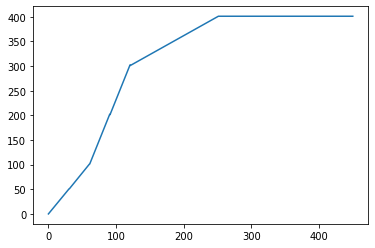

In [50]:
def aqi(x):
    if 0<=int(x)<=30:
        return(50/30*x)
    if 31<=int(x)<=60:
        return(49/29*(x-31)+51)
    if 61<=int(x)<=90:
        return((200-101)/(90-61)*(x-61)+101)
    if 91<=int(x)<=120:
        return(99/(120-91)*(x-91)+201)
    if 121<=int(x)<=250:
        return((400-301)/(250-121)*(x-121)+301)
    if 251<=int(x):
        return(401)
    else:
        return(0)

x_pm25 = np.linspace(0,450,900)
y_aqi = [aqi(e) for e in x_pm25]
plt.plot(x_pm25,y_aqi)

This function awfully looks like a **Logistic Regression** curve of equation:

$$AQI(PM2.5)=\frac{500}{1+e^{-(PM2.5-105.5)}}$$

... which can plot for reference

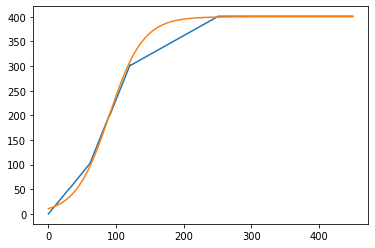

In [77]:
x_pm25 = np.linspace(0,450,900)
y_aqi = [aqi(e) for e in x_pm25]
y_pred_aqi = 400/(1+np.exp(0.4e-1*(-x_pm25+90)))
plt.plot(x_pm25,y_aqi)
plt.plot(x_pm25,y_pred_aqi)

In [33]:
"""Source: https://github.com/jtemporal/folium-101"""
"""Look at: https://towardsdatascience.com/how-to-step-up-your-folium-choropleth-map-skills-17cf6de7c6fe"""

"""
import folium

world = folium.Map(
    zoom_start=100,
    location=[13.133932434766733, 16.103938729508073])
world
"""

'\nimport folium\n\nworld = folium.Map(\n    zoom_start=100,\n    location=[13.133932434766733, 16.103938729508073])\nworld\n'